# I'm Something of a Painter Myself
In this Kaggle competition, we are tasked with creating a Generative Adversarial Network (GAN) that generates images in the style of Monet from target images. This implementation will introduce the **CycleGAN** Model: an architecture that learns the mappings between two domains (images). The primary goal of CycleGAN is to learn mappings between two domains, $X$ and $Y$, in such a way that an image from one domain can be translated into the other domain while preserving the key characteristics of the original image. 

Because of the nature of the CycleGAN, it has two generators ($G$ and $F$) and two discriminators ($D_X$ and $D_Y$), working in pairs for both domains, while a normal GAN only has one generator and one discriminator. A standard GAN also focuses solely on the adversarial loss, aiming to make generated images indistinguishable from real images, while CycleGAN combines adversarial losses with **cycle consistency** loss to ensure not only realism but also that the image can be reverted to its original form after translation:

$$
\begin{aligned} 
\mathcal{L}(G, F, D_X, D_Y) &= \mathcal{L}_{GAN}(G, D_Y, X, Y) + \mathcal{L}_{GAN}(F, D_X, Y, X) + \lambda \mathcal{L}_{cyc}(G, F)
\end{aligned}
$$

**where:**

$$
\begin{aligned}
\mathcal{L}_{GAN}(G, D_Y, X, Y) &= \mathbb{E}_{y \sim p_{data}(y)} [\log D_Y(y)] + \mathbb{E}_{x \sim p_{data}(x)} [\log (1 - D_Y(G(x)))], \\
\mathcal{L}_{GAN}(F, D_X, Y, X) &= \mathbb{E}_{x \sim p_{data}(x)} [\log D_X(x)] + \mathbb{E}_{y \sim p_{data}(y)} [\log (1 - D_X(F(y)))], \\
\mathcal{L}_{cyc}(G, F) &= \mathbb{E}_{x \sim p_{data}(x)} [||F(G(x)) - x||_1] + \mathbb{E}_{y \sim p_{data}(y)} [||G(F(y)) - y||_1]
\end{aligned}
$$

$G$ maps images from domain $X$ to domain $Y$ $(G:X→Y)$, and $F$ maps images from domain $Y$ to domain $X$ $(F:Y→X)$. $D_X$ distinguishes between real images from domain $X$ and generated images $F(Y)$, while $D_Y$ distinguishes between real images from domain $Y$ and generated images $G(X)$. $\lambda$ is a hyperparameter used to control the relative importance of cycle consistency loss compared to adversarial loss.

I used many resources to help create this implementation of CycleGAN:

- [junyanz/CycleGAN on GitHub](https://github.com/junyanz/CycleGAN)
- ["Hands-On Image Generation with TensorFlow" by Packt Publishing](https://www.packtpub.com/en-us/product/hands-on-image-generation-with-tensorflow-9781838826789)
- ["Cycle Generative Adversarial Network (CycleGAN)" on GeeksforGeeks](https://www.geeksforgeeks.org/cycle-generative-adversarial-network-cyclegan-2/)
- ["What is CycleGAN and How to Use It?" on Medium](https://medium.com/imagescv/what-is-cyclegan-and-how-to-use-it-2bfc772e6195)
- ["Building Autoencoders in Keras" on Keras Blog](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Instance Normalization: The Missing Ingredient for Fast Stylization (arXiv)](https://arxiv.org/pdf/1607.08022)

In [1]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install tensorflow 
# !pip install pillow

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.layers import GroupNormalization # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.io.gfile import glob # type: ignore
import matplotlib.pyplot as plt
import numpy as np 

import os
import PIL
import shutil
from typing import Callable, Tuple

E0000 00:00:1719282956.614373    3243 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="localhost"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D0625 02:35:56.622791876    3243 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D0625 02:35:56.622806286    3243 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D0625 02:35:56.622809499    3243 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D0625 02:35:56.622811871    3243 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D0625 02:35:56.622814174    3243 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (d

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("Running on TPU")
except:
        if tf.config.list_physical_devices('GPU'):
            strategy = tf.distribute.MirroredStrategy()
            print("Running on GPU.")
        else:
            strategy = tf.distribute.get_strategy()
            print("Running on CPU.")

Device: 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1719282963.288114    3243 service.cc:145] XLA service 0x5567c8a52310 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719282963.288162    3243 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1719282963.288167    3243 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1719282963.288170    3243 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1719282963.288173    3243 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1719282963.288175    3243 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1719282963.288178    3243 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1719282963.288180    3243 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1719282963.288184    3243 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Running on TPU


## Load & Preprocess Data
We need to load and preprocess the data to make it readable for the model. We will be working with jpg and [tfrec](https://keras.io/examples/keras_recipes/creating_tfrecords/) files for this model. 

The steps for this section are as follows:
- `decode`
- `read`
- `load_dataset`
- `gan_dataset`

Some more resources on tfrec files:
- https://www.kaggle.com/code/matakaggle/read-tfrec-files 

In [4]:
monet_jpg = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_jpg/*.jpg')
photo_jpg = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_jpg/*.jpg')

monet_tfrec = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
photo_tfrec = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')

## Hyperparameters
- `HEIGHT`: This defines the height of the input images. Changing this value can affect the model's performance and training time as it determines the amount of information fed into the model.
- `WIDTH`: This defines the width of the input images. Like height, changing this value impacts the model's performance and training time by altering the input image dimensions.
- `CHANNELS`: This defines the number of color channels in the input images. Typically set to 3 for RGB images, it can be adjusted for different types of input data (e.g., grayscale images with 1 channel).
- `OUTPUT_CHANNELS`: This defines the number of color channels in the output images. It is crucial for tasks like image generation where the output needs to match a certain format.
- `EPOCHS`: This defines the number of complete passes through the training dataset. More epochs can lead to better training results but also increase the risk of overfitting.
- `BATCH_SIZE`: This defines the number of samples processed before the model's internal parameters are updated. It affects the training speed and stability of the optimization process.
- `AUTOTUNE`: This is a setting in TensorFlow that allows automatic optimization of data loading and prefetching. It is a hyperparameter that can be adjusted to improve training performance.

In [5]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
OUTPUT_CHANNELS = 3
EPOCHS = 25
BATCH_SIZE = 16

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
def decode(image: str):
    """Decodes the tfrecord and preprocesses the image.

    Args:
        image (str): Image path

    Returns:
        image: Decoded and preprocessed image
    """
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

In [7]:
def read(example):
    """Reads a TFRecord file and returns the image.

    Args:
        example (tfrec): TFRecord file

    Returns:
        image: Returns image path
    """
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode(example['image'])
    return image

In [8]:
def load_dataset(filenames, labeled=True, ordered=False):
    """Load a dataset from TFRecords.

    Args:
        filenames (object): Glob object with the path to the TFRecords.
        labeled (bool, optional): Is labeled? Defaults to True.
        ordered (bool, optional): Is ordered? Defaults to False.

    Returns:
        dataset (DatasetV2): A tf.data.Dataset object.
    """
    data = tf.data.TFRecordDataset(filenames)
    data = data.map(read, num_parallel_calls=AUTOTUNE)
    return data

In [9]:
def gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):
    """Retrieve the dataset in a format readable for CycleGAN.

    Args:
        monet_files (DatasetV2): Monet dataset.
        photo_files (DatasetV2): Photo dataset.
        augment (str, optional): Augmentation? Defaults to None.
        repeat (bool, optional): Repeat? Defaults to True.
        shuffle (bool, optional): Shuffle? Defaults to True.
        batch_size (int, optional): Batch size. Defaults to 1.

    Returns:
        dataset (DatasetV2): A tf.data.Dataset object.
    """
    monets = load_dataset(monet_files)
    photos = load_dataset(photo_files)
        
    if repeat:
        monets = monets.repeat()
        photos = photos.repeat()
    if shuffle:
        monets = monets.shuffle(2048)
        photos = photos.shuffle(2048)
        
    monets = monets.batch(batch_size, drop_remainder=True)
    photos = photos.batch(batch_size, drop_remainder=True)
    monets = monets.cache()
    photos = photos.cache()
    monets = monets.prefetch(AUTOTUNE)
    photos = photos.prefetch(AUTOTUNE)
    
    dataset = tf.data.Dataset.zip((monets, photos))
    
    return dataset

In [10]:
monet_ds = load_dataset(monet_tfrec, labeled=True).batch(1)
photo_ds = load_dataset(photo_tfrec, labeled=True).batch(1)

# EDA
Findings:
- Monet JPG files: 300
- Photo JPG files: 7038
- Monet tfrec files: 5
- Photo tfrec files: 20

Example images

In [11]:
print(f'Monet JPG files: {len(monet_jpg)}')
print(f'Photo JPG files: {len(photo_jpg)}')

Monet JPG files: 300
Photo JPG files: 7038


In [12]:
print(f'Monet tfrec files: {len(monet_tfrec)}')
print(f'Photo tfrec files: {len(photo_tfrec)}')

Monet tfrec files: 5
Photo tfrec files: 20


In [13]:
ex_m = next(iter(monet_ds))
ex_p = next(iter(photo_ds))

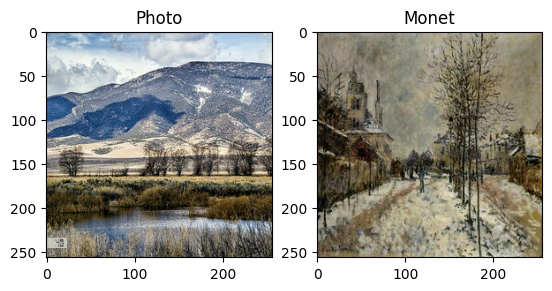

In [14]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(ex_p[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(ex_m[0] * 0.5 + 0.5)

# Model Architecture

## Downsample & Upsample
Implement `downsample` and `upsample` functions:
- **`downsample`**: Downsampling reduces the spatial dimensions of the input image, allowing the network to capture and extract hierarchical features at multiple scales, which decreases the number of computations required and makes it feasible to train deep networks with limited computational resources. As the spatial dimensions decrease, the receptive field of the network increases, allowing for more global context.
- **`upsample`**: Upsampling increases the spatial dimensions of the feature maps, reconstructing the original size of the input image. Fine details and high-frequency information need to be recovered to ensure the output image is visually plausible and retains the structure of the original image. 

We will be using [`Conv2d`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [`Conv2dTranspose`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) from Keras to accomplish this

In [15]:
def downsample(filters: int, size: int, apply_instancenorm: bool = True):
    """Downsamples an input: Conv2D => InstanceNorm => LeakyRelu
    
    Conv2d: This layer reduces the spatial resolution by half and applies a specified number of filters with a given kernel size
    InstanceNorm: A normalization layer that normalizes its inputs using the mean and variance of the current batch of inputs, if applied
    LeakyReLU: Introduces non-linearity and maintains gradient flow for negative inputs

    Args:
        filters (int): Number of filters for layer stack
        size (int): Kernel size
        apply_instancenorm (bool, optional): Apply a GroupNormalization? Defaults to True.

    Returns:
        stack: downsample stack layers using keras.Sequential
    """
    initializer = tf.random_normal_initializer(0., 0.02)

    stack = keras.Sequential()
    stack.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        stack.add(layers.GroupNormalization(groups=-1))

    stack.add(layers.LeakyReLU())

    return stack

In [16]:
def upsample(filters: int, size: int, apply_dropout: bool = True):
    """Upsamples an input: Conv2DTranspose => InstanceNorm => Dropout => Relu
    
    Conv2DTranspose: This layer increases the spatial resolution by a factor of 2 and applies a specified number of filters with a given kernel size.
    GroupNormalization: A normalization layer that normalizes the activations across the feature maps
    Dropout: A regularization layer that applies dropout to the input
    ReLU: Introduces non-linearity and maintains gradient flow for positive inputs

    Args:
        filters (int): Number of filters for layer stack
        size (int): Kernel size
        apply_dropout (bool, optional): Apply dropout? Defaults to False.

    Returns:
        stack: upsample stack using keras.Sequential
    """
    initializer = tf.random_normal_initializer(0., 0.02)

    stack = keras.Sequential()
    stack.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    stack.add(layers.GroupNormalization(groups=-1))
    
    if apply_dropout:
        stack.add(layers.Dropout(0.5))

    stack.add(layers.ReLU())

    return stack

## Generator

In [17]:
def build_generator() -> tf.keras.Model:
    """Builds the generator model for CycleGAN.

    Returns:
        tf.keras.Model: Generator model
    """
    inputs = layers.Input(shape=[HEIGHT, WIDTH, CHANNELS])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [18]:
def generator_example(photo):
    """Generates an example photo.

    Args:
        photo: image to be transformed
    """
    monet_generator = build_generator()
    monet = monet_generator(photo)

    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(photo[0] * 0.5 + 0.5)

    plt.subplot(1, 2, 2)
    plt.title("Monet")
    plt.imshow(monet[0] * 0.5 + 0.5)
    plt.show()

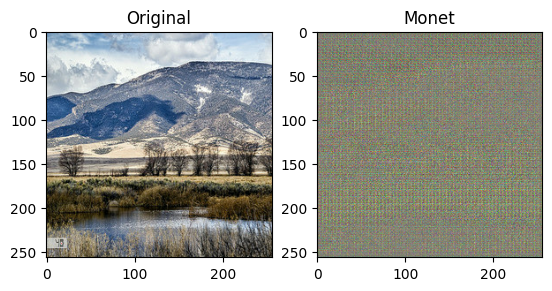

In [19]:
example = generator_example(ex_p)

## Discriminator

In [20]:
def build_discriminator() -> tf.keras.Model:
    """Builds the discriminator model for CycleGAN.

    Returns:
        tf.keras.Model: Discriminator model
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) 
    down2 = downsample(128, 4)(down1) 
    down3 = downsample(256, 4)(down2) 

    zero_pad1 = layers.ZeroPadding2D()(down3) 
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) 

    norm1 = layers.GroupNormalization(groups=-1)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) 

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) 

    return tf.keras.Model(inputs=inp, outputs=last)

# Model Construction

## Inistialize Generators
Create the generators and discriminators to apply to the `CycleGAN` class

In [21]:
with strategy.scope():
    monet_generator = build_generator() 
    photo_generator = build_generator() 

    monet_discriminator = build_discriminator() 
    photo_discriminator = build_discriminator() 

## CycleGAN Model Class
The `CycleGAN` class is a TensorFlow/Keras model that employs two generators and two discriminators. It follows the architecture below:

**Initialization**

Defines and initializes the CycleGAN model with generators and discriminators for both Monet paintings and photos.

- `monet_generator`: Generator to convert photos to Monet-style paintings.
- `photo_generator`: Generator to convert Monet-style paintings to photos.
- `monet_discriminator`: Discriminator to distinguish between real and fake Monet paintings.
- `photo_discriminator`: Discriminator to distinguish between real and fake photos.
- `cycle`: Hyperparameter for the cycle consistency loss.

**Compilation**

Compiles the CycleGAN model with specified optimizers and loss functions for both generators and discriminators.

- `generator_monet_optimizer`: Optimizer for the Monet generator.
- `generator_photo_optimizer`: Optimizer for the Photo generator.
- `discriminator_monet_optimizer`: Optimizer for the Monet discriminator.
- `discriminator_photo_optimizer`: Optimizer for the Photo discriminator.
- `gen_loss_fn`: Generator loss function.
- `disc_loss_fn`: Discriminator loss function.
- `cycle_loss_fn`: Cycle consistency loss function.
- `identity_loss_fn`: Identity mapping loss function.

**Training Step**

Implements the training loop, including forward and backward cycles, identity mapping, and gradient updates.

- `Forward Cycle`: Transforms a photo to a Monet painting and back to a photo.
- `Backward Cycle`: Transforms a Monet painting to a photo and back to a Monet painting.
- `Identity Mapping`: Ensures that the generators can reproduce the input images.
- `Loss Computations`: Calculates generator, cycle consistency, and discriminator losses.
- `Gradients and Updates`: Computes gradients and updates the model parameters.

**Loss Functions**
1. **Discriminator Loss**: Calculates the loss for the discriminators by comparing real and fake images.
    - `real_loss`: Loss for real images.
    - `generated_loss`: Loss for generated images.
    - `total_disc_loss`: Average of the two losses.
2. **Generator Loss**: Calculates the loss for the generators based on how well they can fool the discriminators.
    - `generator_loss`: Loss for generated images compared to "real" labels.
3. **Cycle Consistency Loss**: Calculates the loss ensuring that an image can be translated to the other domain and back to its original form.
    - `loss1`: Mean absolute difference between real and cycled images.
    - `calc_cycle_loss`: Weighted cycle consistency loss.
4. **Identity Loss**: Calculates the loss ensuring that images from one domain are correctly mapped to themselves.
    - `loss`: Mean absolute difference between real and same-domain images.
    - `identity_loss`: Weighted identity loss.

**Optimizers**
1. **General Optimizer**: Defines a general Adam to ensure numerical stability.
2. **Monet Generator Optimizer**: Adam optimizer for the Monet generator.
3. **Photo Generator Optimizer**: Adam optimizer for the Photo generator.
4. **Monet Discriminator Optimizer**: Adam optimizer for the Monet discriminator.
5. **Photo Discriminator Optimizer**: Adam optimizer for the Photo discriminator.

In [22]:
class CycleGAN(keras.Model):
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator,cycle=10):
        """Initializes the CycleGAN model.

        Args:
            monet_generator (tf.keras.Model): Monet generator
            photo_generator (tf.keras.Model): Photo generator
            monet_discriminator (tf.keras.Model): Monet discriminator
            photo_discriminator (tf.keras.Model): Photo discriminator
            cycle (int, optional): lam. Defaults to 10.
        """
        super(CycleGAN, self).__init__()
        self.generator_monet = monet_generator
        self.generator_photo = photo_generator
        self.discriminator_monet = monet_discriminator
        self.discriminator_photo = photo_discriminator
        self.cycle = cycle
        
    def compile(self, 
            monet_gen_optimizer: tf.keras.optimizers.Optimizer,
            photo_gen_optimizer: tf.keras.optimizers.Optimizer,
            monet_disc_optimizer: tf.keras.optimizers.Optimizer,
            photo_disc_optimizer: tf.keras.optimizers.Optimizer,
            gen_loss_fn: Callable[[tf.Tensor], tf.Tensor], 
            disc_loss_fn: Callable[[tf.Tensor, tf.Tensor], tf.Tensor], 
            cycle_loss_fn: Callable[[tf.Tensor, tf.Tensor, float], tf.Tensor], 
            identity_loss_fn: Callable[[tf.Tensor, tf.Tensor, float], tf.Tensor]
       )-> None:
        """Compiles the CycleGAN model, and initializes the optimizers and loss functions.

        Args:
            generator_monet_optimizer (tf.keras.optimizers.Optimizer): Optimizer for the Monet generator
            generator_photo_optimizer (tf.keras.optimizers.Optimizer): Optimizer for the Photo generator
            discriminator_monet_optimizer (tf.keras.optimizers.Optimizer): Optimizer for the Monet discriminator
            discriminator_photo_optimizer (tf.keras.optimizers.Optimizer): Optimizer for the Photo discriminator
            gen_loss_fn ([[tf.Tensor], tf.Tensor]): Generator loss function
            disc_loss_fn ([[tf.Tensor, tf.Tensor], tf.Tensor]): Discriminator loss function
            cycle_loss_fn ([[tf.Tensor, tf.Tensor, float], tf.Tensor]): Cycle loss function
            identity_loss_fn ([tf.Tensor, tf.Tensor, float], tf.Tensor]): Identity loss function
        """
        super(CycleGAN, self).compile()
        self.generator_monet_optimizer = monet_gen_optimizer
        self.generator_photo_optimizer = photo_gen_optimizer
        self.discriminator_monet_optimizer = monet_disc_optimizer
        self.discriminator_photo_optimizer = photo_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
    
    def train_step(self, batch_data: Tuple[tf.Tensor, tf.Tensor]):
        """Trains the model by 
            1) generating images for both monet and photo datasets 
            2) using the discriminator to check the images
            3) evaluating the generator loss
            4) evaluating the total cycle consistency loss
            5) evaluating the total generator loss
            6) evaluating the discriminator loss
            7) calculating the gradients for the generator and discriminator
            8) applying the gradients to the optimizer

        Args:
            batch_data (Tuple[tf.Tensor, tf.Tensor]): Tuple of real images from monet and photo datasets

        Returns:
            losses (dict): Losses
        """
        real_m, real_p = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            fake_m = self.generator_monet(real_p, training=True)
            cycled_p = self.generator_photo(fake_m, training=True)

            fake_p = self.generator_photo(real_m, training=True)
            cycled_m = self.generator_monet(fake_p, training=True)

            same_m = self.generator_monet(real_m, training=True)
            same_p = self.generator_photo(real_p, training=True)

            disc_real_m = self.discriminator_monet(real_m, training=True)
            disc_real_p = self.discriminator_photo(real_p, training=True)

            disc_fake_m = self.discriminator_monet(fake_m, training=True)
            disc_fake_p = self.discriminator_photo(fake_p, training=True)

            monet_gen_loss = self.gen_loss_fn(disc_fake_m)
            photo_gen_loss = self.gen_loss_fn(disc_fake_p)

            total_cycle_loss = self.cycle_loss_fn(real_m, cycled_m, self.cycle) + self.cycle_loss_fn(real_p, cycled_p, self.cycle)

            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_m, same_m, self.cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_p, same_p, self.cycle)

            monet_disc_loss = self.disc_loss_fn(disc_real_m, disc_fake_m)
            photo_disc_loss = self.disc_loss_fn(disc_real_p, disc_fake_p)

#         with strategy.scope():
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.generator_monet.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.generator_photo.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.discriminator_monet.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.discriminator_photo.trainable_variables)

        self.generator_monet_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.generator_monet.trainable_variables))
        self.generator_photo_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.generator_photo.trainable_variables))
        self.discriminator_monet_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.discriminator_monet.trainable_variables))
        self.discriminator_photo_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.discriminator_photo.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }
        
#     def discriminator_loss(self, real, generated):
#         """Calculates the discriminator loss.

#         Args:
#             real (tf.Tensor): Real image data
#             generated (tf.Tensor): Generated image data

#         Returns:
#             loss: Discriminator loss
#         """
#         real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

#         generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

#         total_disc_loss = real_loss + generated_loss

#         return total_disc_loss * 0.5
    
#     def generator_loss(self, generated):
#         """Calculates the generator loss.

#         Args:
#             generated (tf.Tensor): Generated image data

#         Returns:
#             loss: Generator loss
#         """
#         return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
#     def calc_cycle_loss(self, real_image, cycled_image, lam):
#         """Calculates the cycle consistency loss.

#         Args:
#             real_image (tf.Tensor): Real image data
#             cycled_image (tf.Tensor): Cycled image data
#             lam (int): lambda (for cycle consistency loss)

#         Returns:
#             loss: Cycle consistency loss
#         """
#         loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

#         return lam * loss1
    
#     def identity_loss(self, real_image, same_image, lam):
#         """Calculates the identity loss.

#         Args:
#             real_image (tf.Tensor): Real image data
#             same_image (tf.Tensor): Same image data
#             lam (int): lam

#         Returns:
#             loss: Identity loss
#         """
#         loss = tf.reduce_mean(tf.abs(real_image - same_image))
#         return lam * 0.5 * loss
    
#     def cgan_optimizer(self, epsilon: float=2e-4, beta_1: float=0.5):
#         """Optimizer for the CycleGAN model. Will be used for all optimizers and using Adam.

#         Args:
#             epsilon (float, optional): Numerical stability for Adam optimizer. Defaults to 2e-4.
#             beta_1 (float, optional): Float tensor for Adam optimizer. Defaults to 0.5.

#         Returns:
#             tf.Tensor: Optimized generator
#         """
#         return tf.keras.optimizers.Adam(epsilon, beta_1)
    
#     def monet_generator_optimizer(self, epsilon: float=2e-4, beta_1: float=0.5):
#         """Monet generator optimizer.

#         Args:
#             epsilon (float, optional): Numerical stability for Adam optimizer. Defaults to 2e-4.
#             beta_1 (float, optional): Float tensor for Adam optimizer. Defaults to 0.5.

#         Returns:
#             tf.Tensor: Optimized generator
#         """
#         return tf.keras.optimizers.Adam(epsilon, beta_1)
        
#     def photo_generator_optimizer(self, epsilon: float=2e-4, beta_1: float=0.5):
#         """Photo generator optimizer.

#         Args:
#             epsilon (float, optional): Numerical stability for Adam optimizer. Defaults to 2e-4.
#             beta_1 (float, optional): Float tensor for Adam optimizer. Defaults to 0.5.

#         Returns:
#             tf.Tensor: Optimized generator
#         """
#         return tf.keras.optimizers.Adam(epsilon, beta_1)

#     def monet_discriminator_optimizer(self, epsilon: float=2e-4, beta_1: float=0.5):
#         """Monet discriminator optimizer.

#         Args:
#             epsilon (float, optional): Numerical stability for Adam optimizer. Defaults to 2e-4.
#             beta_1 (float, optional): Float tensor for Adam optimizer. Defaults to 0.5.

#         Returns:
#             tf.Tensor: Optimized discriminator
#         """
#         return tf.keras.optimizers.Adam(epsilon, beta_1)
    
#     def photo_discriminator_optimizer(self, epsilon: float=2e-4, beta_1: float=0.5):
#         """Photo discriminator optimizer.

#         Args:
#             epsilon (float, optional): Numerical stability for Adam optimizer. Defaults to 2e-4.
#             beta_1 (float, optional): Float tensor for Adam optimizer. Defaults to 0.5.

#         Returns:
#             tf.Tensor: Optimized discriminator
#         """
#         return tf.keras.optimizers.Adam(epsilon, beta_1)

In [23]:
with strategy.scope():
    def discriminator_loss(real, generated):
        """Calculates the discriminator loss.

         Args:
             real (tf.Tensor): Real image data
             generated (tf.Tensor): Generated image data

         Returns:
             loss: Discriminator loss
         """
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [24]:
with strategy.scope():
    def generator_loss(generated):
        """Calculates the generator loss.

        Args:
            generated (tf.Tensor): Generated image data

        Returns:
            loss: Generator loss
        """
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [25]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, lam):
        """Calculates the cycle consistency loss.

        Args:
            real_image (tf.Tensor): Real image data
            cycled_image (tf.Tensor): Cycled image data
            lam (int): lambda (for cycle consistency loss)

        Returns:
            loss: Cycle consistency loss
        """
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return lam * loss1

In [26]:
with strategy.scope():
    def identity_loss(real_image, same_image, lam):
        """Calculates the identity loss.

         Args:
             real_image (tf.Tensor): Real image data
             same_image (tf.Tensor): Same image data
             lam (int): lam

         Returns:
             loss: Identity loss
         """
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return lam * 0.5 * loss

In [27]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

I0000 00:00:1719282972.069563    3243 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


# Build & Train CycleGAN
Build the`cgan` model and train it

In [29]:
with strategy.scope():
    cgan = CycleGAN(monet_generator, photo_generator, monet_discriminator, photo_discriminator)

In [31]:
with strategy.scope():
    cgan.compile(
        monet_gen_optimizer = monet_generator_optimizer,
        photo_gen_optimizer = photo_generator_optimizer,
        monet_disc_optimizer = monet_discriminator_optimizer,
        photo_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [32]:
cgan.summary()

Model: "cycle_gan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_33 (Functional)      │ ?                      │    54,414,979 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_50 (Functional)      │ ?                      │    54,414,979 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_55 (Functional)      │ ?                      │     2,765,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_60 (Functional)      │ ?                      │     2,765,569 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,361,096 (436.25 MB)

 Trainable params: 114,361,096 (436.25 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# with strategy.scope():
history = cgan.fit(
    gan_dataset(monet_tfrec, photo_tfrec, batch_size=BATCH_SIZE), 
    steps_per_epoch=len(monet_jpg),
    epochs=EPOCHS
).history 

Epoch 1/25


2024-06-25 02:38:42.157485: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1719283124.354669    3986 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(8e2454e2c37c5c6e:0:0), session_name()
I0000 00:00:1719283157.248601    3986 tpu_compile_op_common.cc:245] Compilation of 8e2454e2c37c5c6e:0:0 with session name  took 32.893869621s and succeeded
I0000 00:00:1719283157.342450    3986 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(8e2454e2c37c5c6e:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_5301943132464580862", property.function_library_fingerprint = 4842132930642617092, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z =

300/300 ━━━━━━━━━━━━━━━━━━━━ 131s 119ms/step - monet_disc_loss: 0.6566 - monet_gen_loss: 5.4436 - photo_disc_loss: 0.6645 - photo_gen_loss: 5.4516
Epoch 2/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 3.9955 - photo_disc_loss: 0.6328 - photo_gen_loss: 3.9447
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - monet_disc_loss: 0.6223 - monet_gen_loss: 3.7196 - photo_disc_loss: 0.6213 - photo_gen_loss: 3.7234
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - monet_disc_loss: 0.6287 - monet_gen_loss: 3.4958 - photo_disc_loss: 0.6089 - photo_gen_loss: 3.5957
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - monet_disc_loss: 0.6295 - monet_gen_loss: 3.3485 - photo_disc_loss: 0.6080 - photo_gen_loss: 3.4793
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - monet_disc_loss: 0.6289 - monet_gen_loss: 3.2383 - photo_disc_loss: 0.6023 - photo_gen_loss: 3.3811
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - monet_disc_

# Results & Analysis

In [34]:
def visualize_results(images: int):
    _, ax = plt.subplots(images, 2, figsize=(12, 12))
    for i, img in enumerate(photo_ds.take(images)):
        prediction = monet_generator(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

        ax[i, 0].imshow(img)
        ax[i, 1].imshow(prediction)
        ax[i, 0].set_title("Input Photo")
        ax[i, 1].set_title("Monet-esque")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
    plt.show()

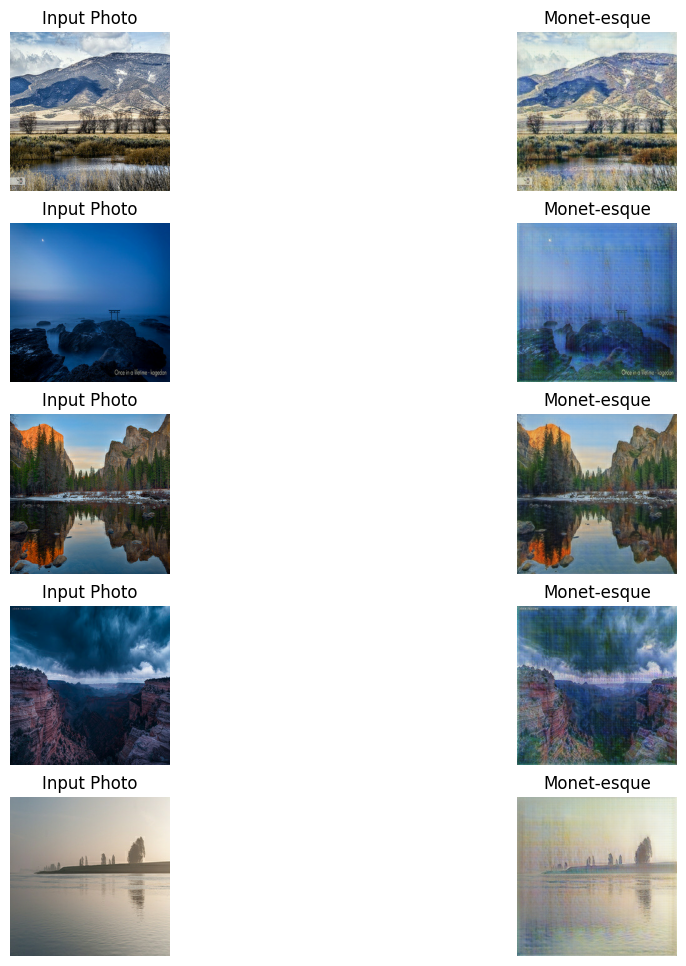

In [35]:
visualize_results(5)

# Test Model
Test the model and create a submission

In [36]:
!mkdir ../images

In [ ]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [ ]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

# Conclusion: Enhancing Model Performance

The model achieved a score of 61.55729. To further improve this score, several strategies can be considered:

1. **Fine-tuning Hyperparameters:** To make the `CycleGAN` produce higher quality outputs, setting up a Pipeline of hyperparameters could provide an opportunity to test out different combinations (this would be very resource intensive).

2. **Data Augmentation:** Implementing techniques such as data augmentation to increase the diversity and size of the training dataset can enhance model robustness and generalization.

3. **Transfer Learning:** Exploration of transfer learning approaches by leveraging pre-trained models or fine-tuning existing ones on specific tasks related to your dataset could increase the score.

4. **Ensemble Methods:** Combining multiple models or predictions through ensemble methods could also potentially achieve higher accuracy and reliability.

By systematically applying these strategies, it is possible to iteratively enhance the model's score and overall effectiveness for the intended application.